In [513]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import trigauss
import mesh
import fem

In [514]:
zx, zw = trigauss.trigauss(8)

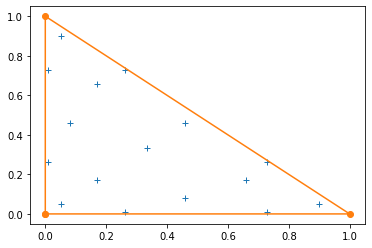

In [515]:
plt.plot(zx[:,0], zx[:,1], '+')
plt.plot([0,1,0,0],[0,0,1,0],'o-')

In [516]:
def inv2x2(A):
    return np.array([[A[1,1], -A[0,1]],[-A[1,0], A[0,0]]])/la.det(A)

In [520]:
def_tri = np.array([
    [0., 1., 0.2],
    [0., 0.5, 1.]
])

def make_trans(def_tri):
    return np.array([
        [def_tri[0,1] - def_tri[0,0], def_tri[0,2] - def_tri[0,0]],
        [def_tri[1,1] - def_tri[1,0], def_tri[1,2] - def_tri[1,0]]
    ])

def trans(tri, pts):
    T = make_trans(tri)
    return T@pts + (tri[:,0])[:,np.newaxis]

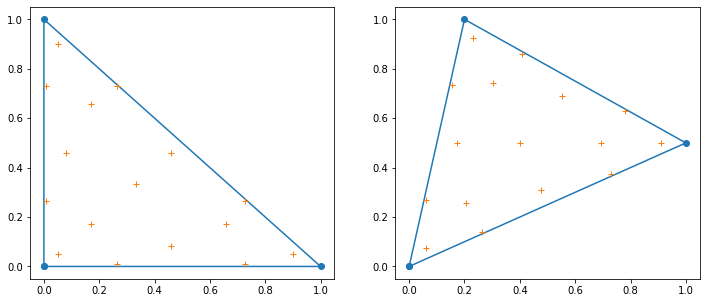

In [521]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot([0,1,0,0],[0,0,1,0],'o-')
x,y = zx.T
ax[0].plot(x,y,'+')

ax[1].plot(np.append(def_tri[0], def_tri[0,0]), np.append(def_tri[1], def_tri[1,0]), 'o-')


ref_x = np.array([0.,1.,0.,0.])
ref_y = np.array([0.,0.,1.,0.])

x,y = trans(def_tri, zx.T)
ax[1].plot(x,y,'+')

In [522]:
v_pts = np.array([
    [0.,1.,0.],
    [0.,0.,1.]
])

def compute_deriv_r(tri, X):
    Dr = np.array([-1.,1.,0.])
    t_pts = trans(tri, X)
    xr = np.zeros(2)
    for i in range(Dr.shape[0]):
        xr += Dr[i] * t_pts[:,i]
    return xr

def compute_deriv_s(tri, X):
    Ds = np.array([-1.,0.,1.])
    t_pts = trans(tri, X)
    xr = np.zeros(2)
    for i in range(Ds.shape[0]):
        xr += Ds[i] * t_pts[:,i]
    return xr

print('dX/dr', compute_deriv_r(def_tri, v_pts))
print('dX/ds', compute_deriv_s(def_tri, v_pts))

dX/dr [1.  0.5]
dX/ds [0.2 1. ]


In [523]:
metrics = np.column_stack([compute_deriv_r(def_tri, v_pts), compute_deriv_s(def_tri, v_pts)])
print('derivative of X wrt r,s\n\n', metrics)

derivative of X wrt r,s

 [[1.  0.2]
 [0.5 1. ]]


In [524]:
inv_metrics = inv2x2(metrics)
print('derivative of r,s wrt x,y\n\n', inv_metrics)
print('||dX/dR * dR/dX|| =', la.norm(metrics@inv_metrics, 2))

derivative of r,s wrt x,y

 [[ 1.11111111 -0.22222222]
 [-0.55555556  1.11111111]]
||dX/dR * dR/dX|| = 1.0


In [525]:
J = la.det(metrics)
print('Jacobian', J)

Jacobian 0.9


In [526]:
Rmat = sp.kron(inv_metrics, sp.eye(len(zx)))
Rmat.shape

(32, 32)

In [527]:
Btilde = sp.diags([zw * J], [0])
print(Btilde.diagonal())
Btilde.shape

[0.06494202 0.04279124 0.04279124 0.04279124 0.04644782 0.04644782
 0.04644782 0.01460632 0.01460632 0.01460632 0.01225364 0.01225364
 0.01225364 0.01225364 0.01225364 0.01225364]


(16, 16)

In [528]:
Dr = np.array([-1.,1.,0.])
Drr = np.row_stack([Dr] * len(zx))
Ds = np.array([-1.,0.,1.])
Dss = np.row_stack([Ds] * len(zx))
Dmat = np.vstack([Drr,Dss])

In [529]:
A = Dmat.T @ Rmat.T @ sp.kron(Btilde, sp.eye(2)) @ Rmat @ Dmat
A

array([[ 0.6121816 , -0.6225402 ,  0.0103586 ],
       [-0.6225402 ,  0.92086204, -0.29832185],
       [ 0.0103586 , -0.29832185,  0.28796325]])

In [16]:
points = np.array([
    [0.0, 0.0], #0
    [0.5, 0.0], #1
    [1.0, 0.0], #2
    
    [0.0, 0.5], #3
    [0.5, 0.5], #4
    [1.0, 0.5], #5
    
    [0.0, 1.0], #6
    [0.5, 1.0], #7
    [1.0, 1.0], #8
])

triangles = np.array([
    [0,1,3], [1,4,3],
    [1,2,4], [2,5,4],
    [3,4,6], [4,7,6],
    [4,5,7], [5,8,7]
], dtype=np.int64)

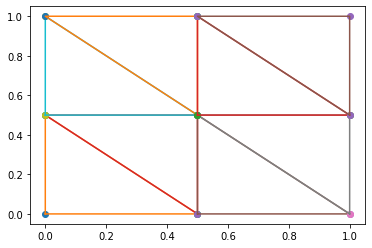

In [17]:
fem.draw_triangles(points, triangles)

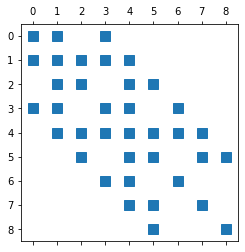

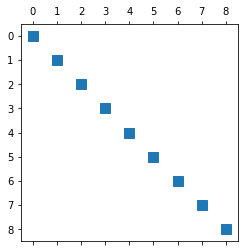

In [18]:
A,B = fem.assemble_matrices(points, triangles)
for a in (A,B):
    plt.figure()
    plt.spy(a)

In [19]:
def plot_soln(points, triangles, u):
    plt.tripcolor(points[:,0], points[:,1], triangles, u, shading='gouraud')

In [20]:
bcs = np.array([1,0,0,1,0,0,1,0,0], dtype=np.float64)
bc_idx = [0,2,3,5,6,8]
R = fem.create_restriction(A.shape[0],bc_idx)
rhs = np.zeros(A.shape[0])
for bc in bc_idx:
    col = np.array(A[:,bc].todense()).flatten()
    rhs -= col * bcs[bc]

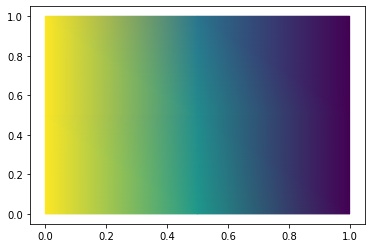

In [21]:
# BCs - dirichlet left 1.0, dirichlet right 0.0, top/bottom neumann
u = R@spla.spsolve(R.T@A@R, R.T@rhs) + bcs
plot_soln(points, triangles, u)

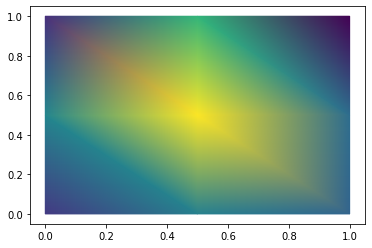

In [22]:
# pure neumann BCs, forcing term at (0.5,0.5)
u = spla.lsqr(A, B@np.array([0.,0.,0.,0.,1.,0.,0.,0.,0.,]))[0]
plot_soln(points, triangles, u)

In [530]:
pts, tris, boundaries = mesh.load_mesh('bfs.msh')
pts = pts[:,:2]

A,B = fem.assemble_matrices(pts, tris)

In [531]:
from functools import reduce
def union_many(boundaries):
    return reduce(np.union1d, boundaries)

In [552]:
boundary_nodes = union_many(boundaries)

def bval(xy):
    x,y = xy
    return x

boundary_values = np.apply_along_axis(bval, 1, pts[boundary_nodes])

In [553]:
R = fem.create_restriction(A.shape[0], boundary_nodes)

0.0 4.0


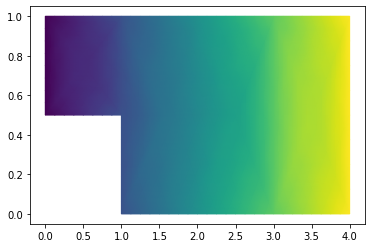

In [554]:
rhs = np.zeros(A.shape[0])
bcs = np.zeros(A.shape[0])

for i, bc in enumerate(boundary_nodes):
    col = np.array(A[:,bc].todense()).flatten()
    rhs -= col * boundary_values[i]
    bcs[bc] = boundary_values[i]
u = R@spla.spsolve(R.T@A@R, R.T@rhs) + bcs
print(np.min(u), np.max(u))
plot_soln(pts, tris, u)

In [555]:
u = np.zeros(A.shape[0])
dt=.2
u[boundary_nodes] = boundary_values
H = spla.inv(B.tocsc())@A

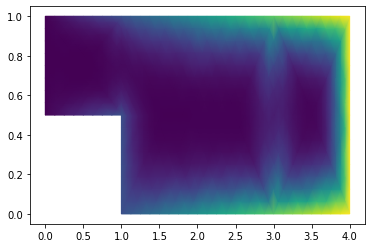

In [571]:
dudt = -H@u
u += dudt*dt

u[boundary_nodes] = boundary_values

plot_soln(pts, tris, u)